## Absolute astrometric calibration

We now have a combined, science-ready image... sort of.  In reality, doing any sort of scientific analysis on this image as it stands will be a big pain, because it doesn't contain any positional information.  If we wanted to extract information about a particular star or galaxy, or (worse) a whole list of objects, this would be extremely frustrating: we would have to scan the image by eye to find each object, write down its pixel coordinates, and send them one-by-one to our photometry or other analysis code.

Fortunately, the FITS format can encode astrometric (positional) information via the header, enabling us to transform (x,y) to (RA,Dec) and back again for any location in the image.  Basic header keywords encode the position, pixel scale, and rotation of the image (plus the spherical projection to be used); these are fully standardized and supported by nearly all astronomical software.  Additional keywords provide distortion terms to allow for deviations from perfectly rectilinear CCD/optics, although unfortunately there are several conflicting conventions for treating distortions and there is no guarantee that your software will support them correctly.

Solving astrometry requires matching a group of stars detected in your image to the stars in the catalog, and solving (fitting) for the parameters in the system of astrometric equations that relate pixel coordinates (x,y) to world coordinates (RA,Dec).  Doing this by hand is painstaking so we will use tools available that will do the astronomy or us. What we need is just a transformation matrix for going from one coordinate system to the other.

Download the **astrometry net client** module in a different virtual environment to avoid dependency clashes. Ony the following cell requires this module.

`$ pip install astrometry-net-client`

Login to *nova.astrometry.net* and get your API key from profile section.

In [12]:
'''
###___Uncomment this cell___###

from astrometry_net_client import Session
from astrometry_net_client import FileUpload

# I have done it for a single file, do it for the combined file you created last time

s = Session(api_key='ipqsipiwjkjgorfv')
upl = FileUpload('/home/welcome/KSP/image_reduction/processing/acam762.proc.fits', session=s)
submission = upl.submit()
submission.until_done()
job = submission.jobs[0]
job.until_done()

if job.success():
    wcs = job.wcs_file()     
    corrTable2 = job.corr_file() # contains the positions in pixel coordinates of the stars detected
    astromFile = job.new_fits_file() # contains the original file you uploaded with the header containing the transformation matrix

    starsTable2.writeto('/home/welcome/KSP/image_reduction/processing/corr2.fits', overwrite=True)
    astromFile.writeto('/home/welcome/KSP/image_reduction/processing/acam762.proc.fits', overwrite=True)      

print(job.info())
'''

"\n###___Uncomment this cell___###\n\nfrom astrometry_net_client import Session\nfrom astrometry_net_client import FileUpload\n\n# I have done it for a single file, do it for the combined file you created last time\n\ns = Session(api_key='ipqsipiwjkjgorfv')\nupl = FileUpload('/home/welcome/KSP/image_reduction/processing/acam762.proc.fits', session=s)\nsubmission = upl.submit()\nsubmission.until_done()\njob = submission.jobs[0]\njob.until_done()\n\nif job.success():\n    wcs = job.wcs_file()     \n    corrTable2 = job.corr_file() # contains the positions in pixel coordinates of the stars detected\n    astromFile = job.new_fits_file() # contains the original file you uploaded with the header containing the transformation matrix\n\n    starsTable2.writeto('/home/welcome/KSP/image_reduction/processing/corr2.fits', overwrite=True)\n    astromFile.writeto('/home/welcome/KSP/image_reduction/processing/acam762.proc.fits', overwrite=True)      \n\nprint(job.info())\n"

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
import warnings
import os
import subprocess

warnings.filterwarnings("ignore")

We're using an Astropy Table, read about it from here https://docs.astropy.org/en/stable/api/astropy.table.Table.html. Using it's data is similar to **pandas**.

In [18]:
corr2 = fits.open('/home/aditi/ksp/data/task-3/corr.fits')

data = corr2[1].data
table = Table(data)

print(table)

     field_x            field_y       ...    FLUX   BACKGROUND
------------------ ------------------ ... --------- ----------
468.62896728515625    518.43505859375 ...  55712.93  32748.164
   1667.2529296875  291.9779357910156 ... 29256.656  32761.164
  3028.98779296875 1828.1341552734375 ... 26839.928   32760.81
     2976.39453125  3233.650146484375 ... 22257.557  32760.549
1883.1834716796875    2997.1279296875 ...  8725.678  32763.947
     3068.67578125 1020.4618530273438 ... 3280.1953  32758.719
 3330.956298828125  2331.105224609375 ... 20181.713  32759.365
   1298.9580078125 467.74322509765625 ... 12018.098   32761.39
 3159.869384765625       2818.2421875 ... 6657.9746  32759.795
     2061.54296875 2011.6976318359375 ... 6486.4395  32763.623
177.75526428222656   1361.09814453125 ... 7030.2617  32756.035
   3280.0693359375      1534.05859375 ...  5791.711  32759.078


Now we'll plot the reference stars the software used to obtain the trasformation to see if it did that correctly

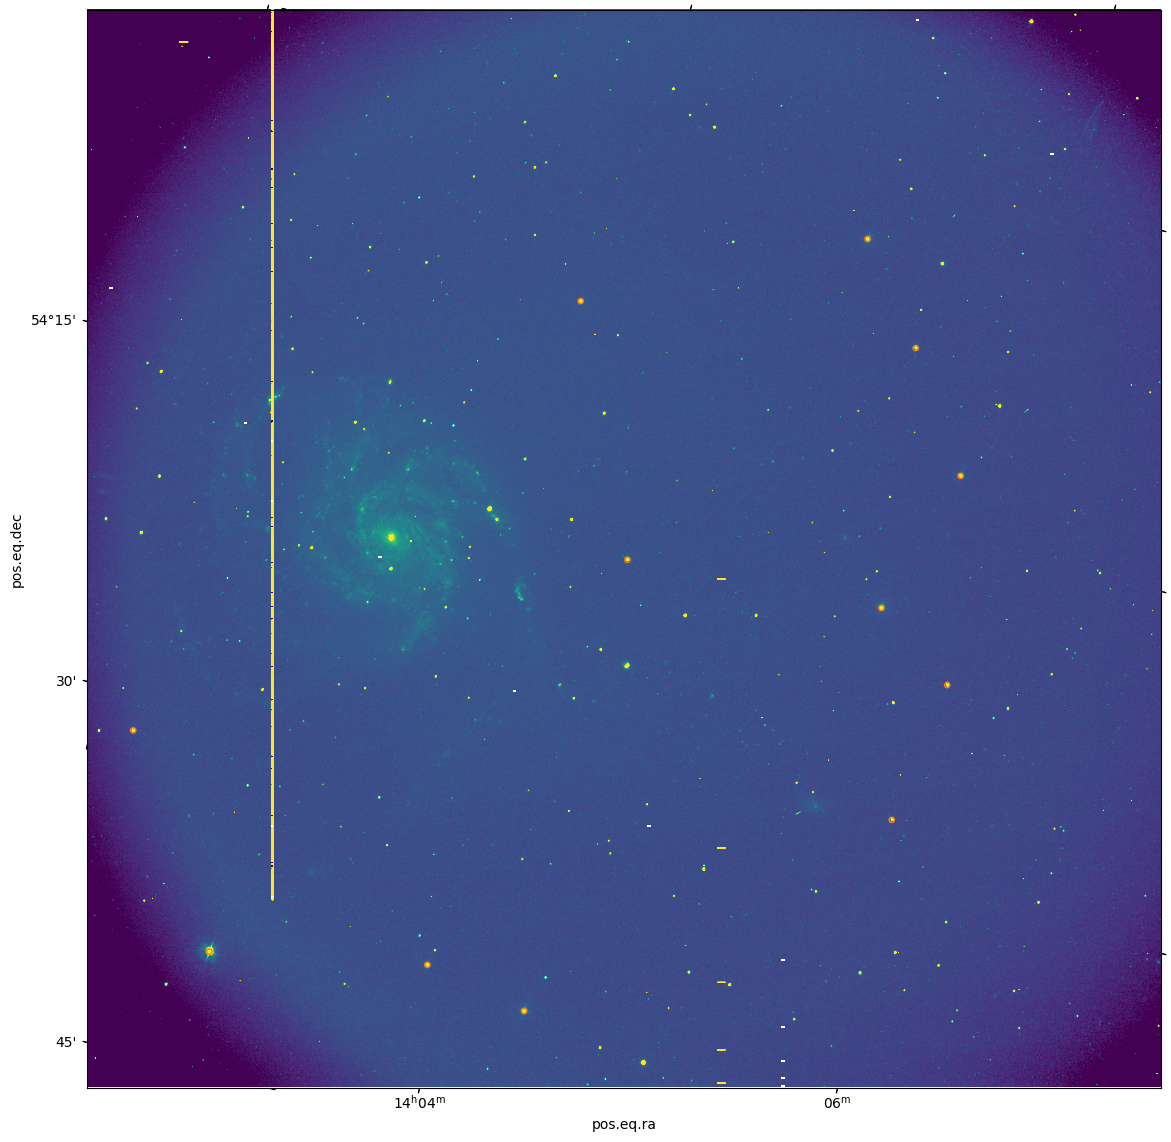

In [19]:
astromFile = '/home/aditi/ksp/data/processing/20230523210842-911-RA.proc.fits'

with fits.open(astromFile) as HDUList:
    img = HDUList[0].data
    header = HDUList[0].header
wcsFile='/home/aditi/ksp/data/task-3/wcs.fits'
with fits.open(wcsFile) as HDUList:
    header = HDUList[0].header
wcs = WCS(header) # the following obtains the transformation matrix from the header

ra = data['field_ra']
dec = data['field_dec']

# changing the coordinates of reference stars from WCS to pixels using tranformation obtained by solving astrometry
coordsx, coordsy = wcs.all_world2pix(ra, dec, 0) 

patch_list = [Circle((x, y), radius=10, fill=False, ec='C1') for x, y in zip(coordsx, coordsy)]

fig = plt.figure(figsize=(14,14))
ax = plt.subplot(projection=wcs) # changes the coordinate system to WCS
mean, median, std = sigma_clipped_stats(img)

plt.imshow(img, vmin=median-3*std, vmax=median+10*std, origin="lower")

for p in patch_list:
    ax.add_patch(p)

plt.show()

You can see that the reference stars align with our image, hence we must be doing something right.

## Resampling

The above image does not have North up and East to the left, the normal convention for displaying astronomical images.  The easiest way to project an image to the standard reference system is to resample it using SWarp, another piece of external code.  This can be done as follows:

In [20]:
swarpConfigFile = '/home/aditi/ksp/stack.swarp'
procFolder = '/home/aditi/ksp/data/processing'
weightFile = os.path.join(procFolder, '20230523210842-911-RA.proc.fits')
resampledFile = os.path.join('/home/aditi/ksp/data/task-3/', '20230520151900-863-RA_resampled.fits')
swarpCommand = 'SWarp' # Change this if you get an error below

try:
    #IMAGEOUT_NAME is the output stacked file, RESAMPLE_DIR is the directory where the resampled images are to be stored

    command = '%s %s -c %s -IMAGEOUT_NAME %s -WEIGHTOUT_NAME %s -RESAMPLE_DIR %s' % (swarpCommand, astromFile, swarpConfigFile, resampledFile, weightFile, procFolder)
    print("Executing command: %s" % command)
    print("Processing...")
    rval = subprocess.run(command.split(), check=True, capture_output=True)
    print("Process completed.")
    print(rval.stdout.decode())

except subprocess.CalledProcessError as err:
    print('Could not run SWarp. Can you run it from the terminal?')

Executing command: SWarp /home/aditi/ksp/data/processing/20230523210842-911-RA.proc.fits -c /home/aditi/ksp/stack.swarp -IMAGEOUT_NAME /home/aditi/ksp/data/task-3/20230520151900-863-RA_resampled.fits -WEIGHTOUT_NAME /home/aditi/ksp/data/processing/20230523210842-911-RA.proc.fits -RESAMPLE_DIR /home/aditi/ksp/data/processing
Processing...
Process completed.



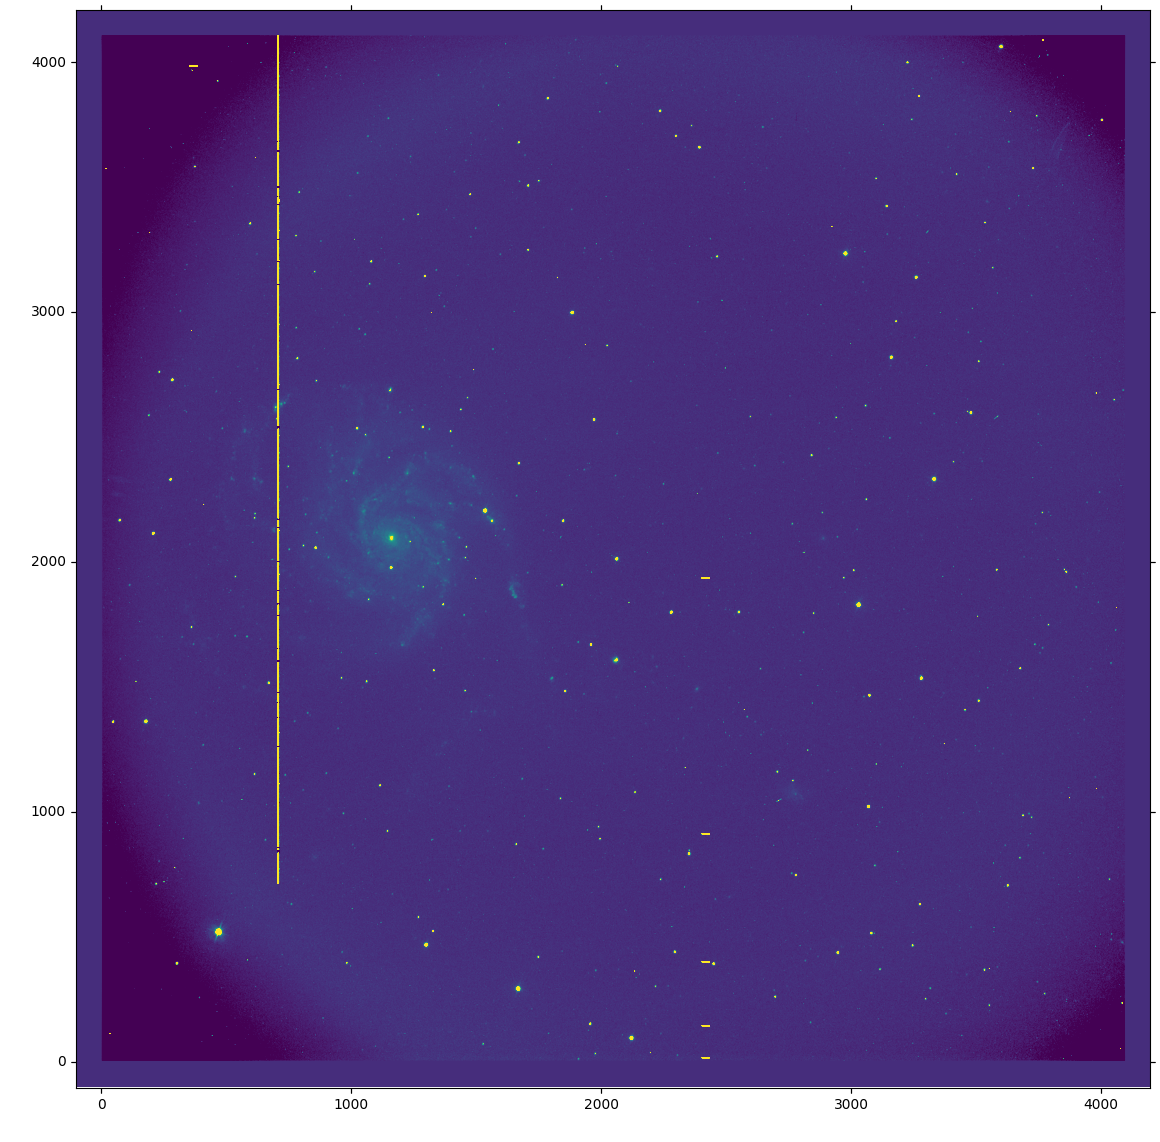

In [21]:
## Display the resampled image

HDUList = fits.open(resampledFile)
wcs = WCS(HDUList[0].header)
resampledData = HDUList[0].data
HDUList.close()

fig = plt.figure(figsize=(14,14))
ax = plt.subplot(projection=wcs)
mean, median, std = sigma_clipped_stats(resampledData)
plt.imshow(resampledData, vmin=mean-3*std, vmax=mean+20*std, origin="lower")
plt.show()